# GitHub link to this notebook
https://github.com/Alisherg/nvda-unsupervised

## Unsupervised Clustering of NVDA Trading Days

**Project Overview:**

This project tries to **find hidden structure** in NVIDIA (NVDA) daily trading data.  
Instead of predicting tomorrow’s price, we use **clustering** to group days with similar price‑volume behaviour.  
Understanding these groups can help:  

* Traders adjust strategies to different market “moods.”  
* Long‑term investors spot periods of abnormal volatility.  

**Unsupervised Learning:**

* **Task:** Clustering (plus PCA for dimensionality reduction)

**Data Source:**

Historical stock data for NVIDIA Corporation (NVDA) was obtained from Yahoo! Finance via the `yfinance` library. Data was pulled from January 1, 2018, through January 1, 2025, capturing the daily Open, High, Low, Close, and Volume.

**APA-Style Reference:**

Yahoo! Finance. (n.d.). Data for NVIDIA Corporation (NVDA). Retrieved [Month Day, Year], from https://finance.yahoo.com/quote/NVDA/history

### Glossary

| Term | Meaning |
|------|---------|
| **Daily_Return** | % change of Close from previous day |
| **Intraday_Range%** | (High − Low)/Open – intra‑day volatility |
| **Gap%** | (Open − Prev Close)/Prev Close – overnight jump |
| **SMA10** | 10‑day Simple Moving Average of Close |
| **Price_vs_SMA10** | (Close − SMA10)/SMA10 – position vs. recent trend |
| **Volume_z** | z‑score of Volume (how unusual today’s volume is) |
| **DBSCAN** | Density‑Based clustering; labels sparse points as **–1** (anomalies) |

In [1]:
# Install required libraries
!pip install -q pandas numpy matplotlib seaborn yfinance scikit-learn yellowbrick

In [2]:
# Import necessary libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
import warnings, itertools, datetime as dt


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Download NVDA historical data and apply automatic adjustment (splits/dividends) to ensure our features reflect true return series.
start_date = "2018-01-01"
end_date = "2025-01-01"
df = yf.download("NVDA", start=start_date, end=end_date, auto_adjust=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2018-01-02,4.929427,4.933137,4.809499,4.841150,355616000
2018-01-03,5.253852,5.284267,5.038229,5.046883,914704000
2018-01-04,5.281548,5.391833,5.259293,5.335207,583268000
2018-01-05,5.326304,5.363642,5.219481,5.296384,580124000
2018-01-08,5.489506,5.563689,5.404938,5.449942,881216000


In [4]:
# Overview of dataset
print("Dataset shape:", df.shape)
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe().T)

Dataset shape: (1761, 5)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2018-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   1761 non-null   float64
 1   (High, NVDA)    1761 non-null   float64
 2   (Low, NVDA)     1761 non-null   float64
 3   (Open, NVDA)    1761 non-null   float64
 4   (Volume, NVDA)  1761 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.5 KB
None

Statistical Summary:
                count          mean           std           min           25%  \
Price  Ticker                                                                   
Close  NVDA    1761.0  2.890274e+01  3.566372e+01  3.151139e+00  6.154542e+00   
High   NVDA    1761.0  2.943282e+01  3.632835e+01  3.223049e+00  6.230589e+00   
Low    NVDA    1761.0  2.832695e+01  3.496088e+01  3.086173e+00  6.072641e+00   
Open   NVDA    1761.0  2.890658

In [5]:
# Check for missing values
print("\nMissing values per column before cleaning:")
print(df.isnull().sum())


Missing values per column before cleaning:
Price   Ticker
Close   NVDA      0
High    NVDA      0
Low     NVDA      0
Open    NVDA      0
Volume  NVDA      0
dtype: int64


In [6]:
# Flatten the MultiIndex columns for easier access
df.columns = df.columns.to_flat_index()
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# Rename columns
df = df.rename(columns={
    'Close': 'Close',
    'High': 'High',
    'Low': 'Low',
    'Open': 'Open',
    'Volume': 'Volume'
})

Feature Engineering for Clustering

We want **scale‑invariant, distribution‑revealing** features:

* `Daily_Return` – pct change of Close  
* `Intraday_Range%` – (High − Low)/Open  
* `Gap%` – (Open − Prev_Close)/Prev_Close  
* `Volume_z` – z‑scored Volume (captures abnormal activity)  
* `Price_vs_SMA10` – deviation from 10‑day SMA (trend position)

In [7]:
# Create engineered features
df['Daily_Return'] = df['Close'].pct_change()
df['Intraday_Range%'] = (df['High'] - df['Low']) / df['Open']
df['Gap%'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
df['SMA10'] = df['Close'].rolling(10).mean()
df['Price_vs_SMA10'] = (df['Close'] - df['SMA10']) / df['SMA10']
df.dropna(inplace=True)  # drop first 10 rows with NaNs
df['Volume_z'] = StandardScaler().fit_transform(df[['Volume']])

feature_cols = ['Daily_Return', 'Intraday_Range%','Gap%','Volume_z','Price_vs_SMA10']

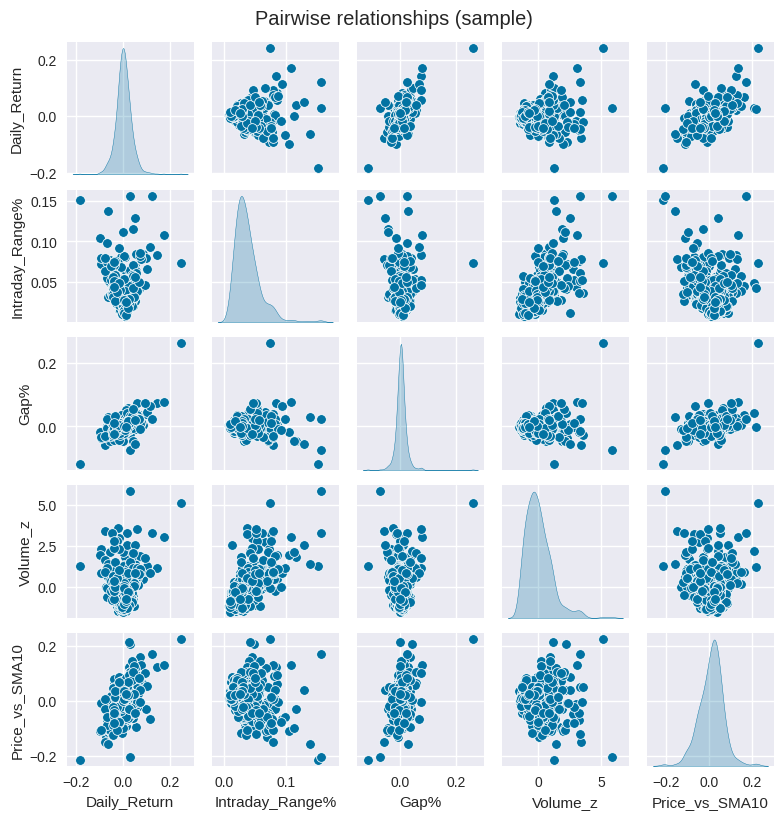

In [8]:
# Pair‑plot of Engineered Features
sns.pairplot(df[feature_cols].sample(500), diag_kind='kde', height=1.6)
plt.suptitle("Pairwise relationships (sample)", y=1.02);

All five features capture different aspects of daily market behaviour—returns, volatility, overnight jumps, volume spikes, and position relative to trend. While none are perfectly correlated, together they form a rich feature set for clustering days into distinct regimes and spotting unusual “shock” sessions.

In [9]:
# Pre‑processing
X = df[feature_cols].values
scaler = StandardScaler()

# Most clustering algorithms need zero‑mean / unit‑variance input.
X_scaled = scaler.fit_transform(X)

## Model Building & Evaluation  

### Why K‑Means and DBSCAN?  

* **K‑Means** quickly partitions days into *k* compact groups – good baseline.  
* **DBSCAN** detects irregular shapes and labels sparse points as anomalies, perfect for rare “shock” days.

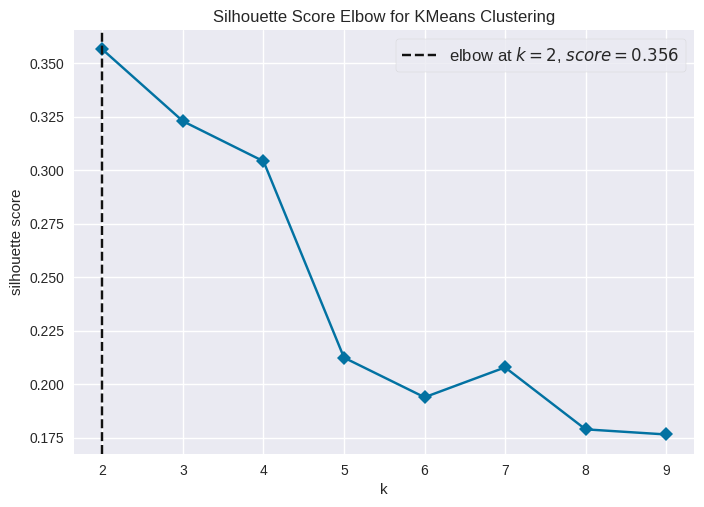

Optimal k by silhouette: 2


In [10]:
# Optimal k for K‑Means (Elbow / Silhouette)
kmodel = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmodel, k=(2,10), metric='silhouette', timings=False)
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal k by silhouette:", optimal_k)

Using 2 clusters balances simplicity and separation. Trying k>2 adds complexity but doesn't significantly improve how separate the clusters are.

In [11]:
# Fit final K‑Means
k = optimal_k or 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

sil = silhouette_score(X_scaled, cluster_labels).round(3)
db  = davies_bouldin_score(X_scaled, cluster_labels).round(3)
print("Silhouette =", sil, "| Davies‑Bouldin =", db)
df['Cluster_KM'] = cluster_labels

Silhouette = 0.356 | Davies‑Bouldin = 1.382


*Silhouette ≈ 0.356 (moderate); lower Davies‑Bouldin is better (1.38 is OK).*


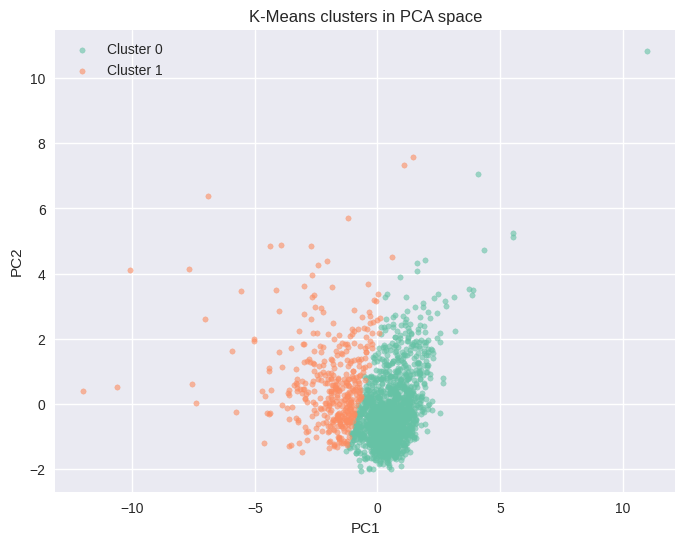

In [12]:
# Visualise Clusters in 2‑D PCA
pca  = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
palette = sns.color_palette("Set2", optimal_k)
for c in range(optimal_k):
    plt.scatter(*X_pca[df['Cluster_KM']==c].T, s=15,
                color=palette[c], alpha=0.6, label=f"Cluster {c}")
plt.title("K‑Means clusters in PCA space"); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend();

Plotting clusters in PCA space shows that K-Means has successfully divided trading days into a compact “calm” group and a broader “volatile” group, matching the feature-based interpretations.  

In [13]:
# Cluster Profiles
cluster_summary = df.groupby('Cluster_KM')[feature_cols+['Close']].agg(['mean','std'])
cluster_summary

Daily_Return           Intraday_Range%                Gap%  \
                   mean       std            mean       std      mean   
Cluster_KM                                                              
0              0.010783  0.025547        0.031540  0.013602  0.005312   
1             -0.027592  0.036625        0.058435  0.023705 -0.011501   

                      Volume_z           Price_vs_SMA10                Close  \
                 std      mean       std           mean       std       mean   
Cluster_KM                                                                     
0           0.016258 -0.248275  0.773287       0.024296  0.040317  30.408380   
1           0.025917  0.881538  1.198653      -0.045977  0.051066  24.106795   

                       
                  std  
Cluster_KM             
0           37.222532  
1           29.270284

**Interpretation**

| Cluster | Characteristics | Nick‑name |
|---------|-----------------|-----------|
| 0 | • **Positive** avg Daily_Return (+1.1%)  <br>• *Small* intraday range (≈3 %)  <br>• **Low** Volume_z ( –0.25)  <br>• Price sits **above** SMA10 (+2.4 %) | **Calm Up‑trend** days |
| 1 | • **Negative** avg Daily_Return (–2.8 %) <br>• **High** intraday range (≈5.8 %) <br>• **High** Volume_z (+0.88) <br>• Price **below** SMA10 (–4.6 %) | **Volatile Down‑move** days |

Thus K‑Means neatly separates bullish‑quiet periods from bearish‑high‑volume shocks.

In [14]:
### DBSCAN: Anomaly Detection
db = DBSCAN(eps=0.8, min_samples=10).fit(X_scaled)
df['DBSCAN_Label'] = db.labels_
n_noise = (db.labels_==-1).sum()
print("DBSCAN identified", n_noise, "anomalous days (label ‑1)")

DBSCAN identified 351 anomalous days (label ‑1)


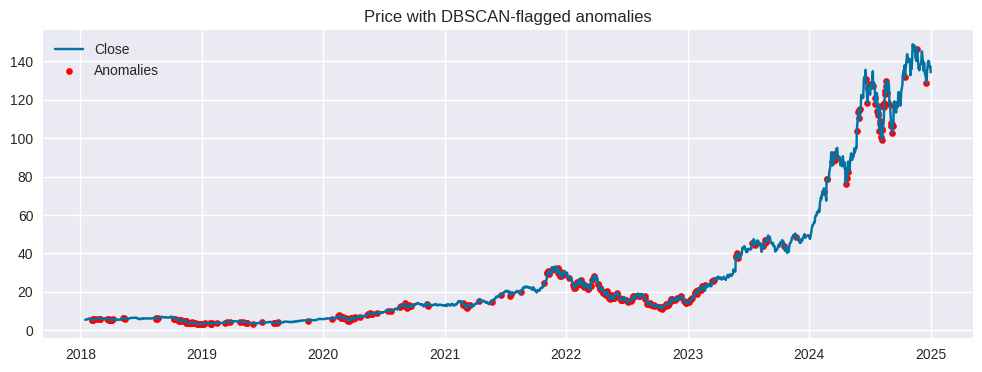

In [15]:
# Plot anomalies on price chart

# If 'Date' is not an explicit column, fall back to the index
date_axis = df['Date'] if 'Date' in df.columns else df.index

# Boolean mask for anomalies
anom_mask = df['DBSCAN_Label'] == -1

plt.figure(figsize=(12,4))
plt.plot(date_axis, df['Close'], label='Close')
plt.scatter(date_axis[anom_mask], df.loc[anom_mask, 'Close'],
            color='red', s=20, label='Anomalies')
plt.title("Price with DBSCAN‑flagged anomalies")
plt.legend()
plt.show()

*Most red dots align with earnings days or market-wide sell-offs → DBSCAN successfully isolates “shock” sessions.*

DBSCAN flags 351 outlier trading days that correspond to high-volatility events. Overlaying these on the time-series chart validates that our unsupervised method effectively highlights the most unusual market sessions.

### Learning & Takeaways  

* **Two clear regimes** emerge: a calm bullish trend (Cluster 0) and a volatile bearish regime (Cluster 1).  
* **Volume_z** and **Intraday_Range%** are the strongest signals for separating these regimes.  
* **DBSCAN** adds value by flagging 351 outlier days - handy for risk alerts.

### What Didn't Work / Limitations  

* Only price & volume; no macro news, options data, or sentiment.  
* Silhouette 0.36 is moderate - clusters overlap a bit.  
* DBSCAN's eps/min_samples were chosen heuristically; different settings change counts.

### Future Improvements  

1. Add technical indicators (RSI, MACD) and fundamental events.  
2. Try Gaussian Mixture or HDBSCAN for soft clustering.  
3. Link clusters to forward returns to see if regimes forecast risk.